First pre-optimization image:


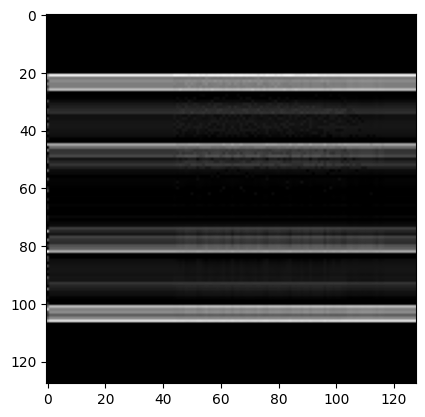

First post-optimization image:


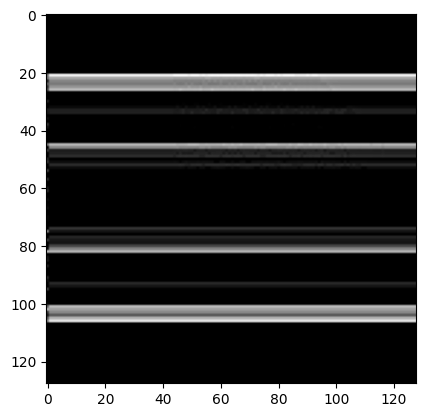

In [2]:
import numpy as np
import os
import sys
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# Set the paths to the image folders
pre_optimization_folder = './128x128/preProjectionSeq/'
post_optimization_folder = './128x128/ImageSeq/'

start_time = time.time()

# Function to load grayscale images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

# Load pre-optimization grayscale images
pre_optimization_images = load_images_from_folder(pre_optimization_folder)

# Load post-optimization grayscale images
post_optimization_images = load_images_from_folder(post_optimization_folder)

# Convert image lists to numpy arrays
pre_optimization_images = np.array(pre_optimization_images)
post_optimization_images = np.array(post_optimization_images)

# Normalize the image data
pre_optimization_images = pre_optimization_images / 255.0
post_optimization_images = post_optimization_images / 255.0

# Convert numpy arrays to PyTorch tensors
x_train = torch.from_numpy(pre_optimization_images).unsqueeze(1).float()
y_train = torch.from_numpy(post_optimization_images).unsqueeze(1).float()


print("First pre-optimization image:")
plt.imshow(pre_optimization_images[0], cmap='gray')
plt.show()

print("First post-optimization image:")
plt.imshow(post_optimization_images[0], cmap='gray')
plt.show()


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.middle_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        )

        self.decoder = nn.Sequential(
            
            nn.Conv2d(192, 64, kernel_size=3, padding=1),  # Concatenating feature maps from the encoder
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        encoder_output1 = self.encoder(x)
        encoder_output2 = self.middle_conv(encoder_output1)
        decoder_input = torch.cat([encoder_output2, encoder_output1], dim=1)  # Concatenate feature maps
        decoder_output = self.decoder(decoder_input)
        return decoder_output
  
    
model = UNet()
modelFile = "./model_128x128_200_epoch.pth"
model.load_state_dict(torch.load(modelFile))
model.eval()



UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (middle_conv): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): GELU(approximate='none')
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GELU(approximate='none')
    (5): Upsample(scale_factor=2.0, mode='bilinear')
  )
  (decoder): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import time
import os
import sys
import cv2

device_count = torch.cuda.device_count()
if device_count > 0:
    print("Available GPUs:")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available. PyTorch is using CPU.")

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    model = model.to(device)
    print("PyTorch is using GPU.")
else:
    print("PyTorch is using CPU.")

# Convert the data to the appropriate device
x_train = x_train.to(device)
y_train = y_train.to(device)

dataset = TensorDataset(x_train, y_train)

# Create PyTorch DataLoaders for training and validation
dataloader = DataLoader(dataset = dataset, batch_size=360, shuffle=False)


Available GPUs:
GPU 0: NVIDIA RTX A5000
PyTorch is using GPU.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


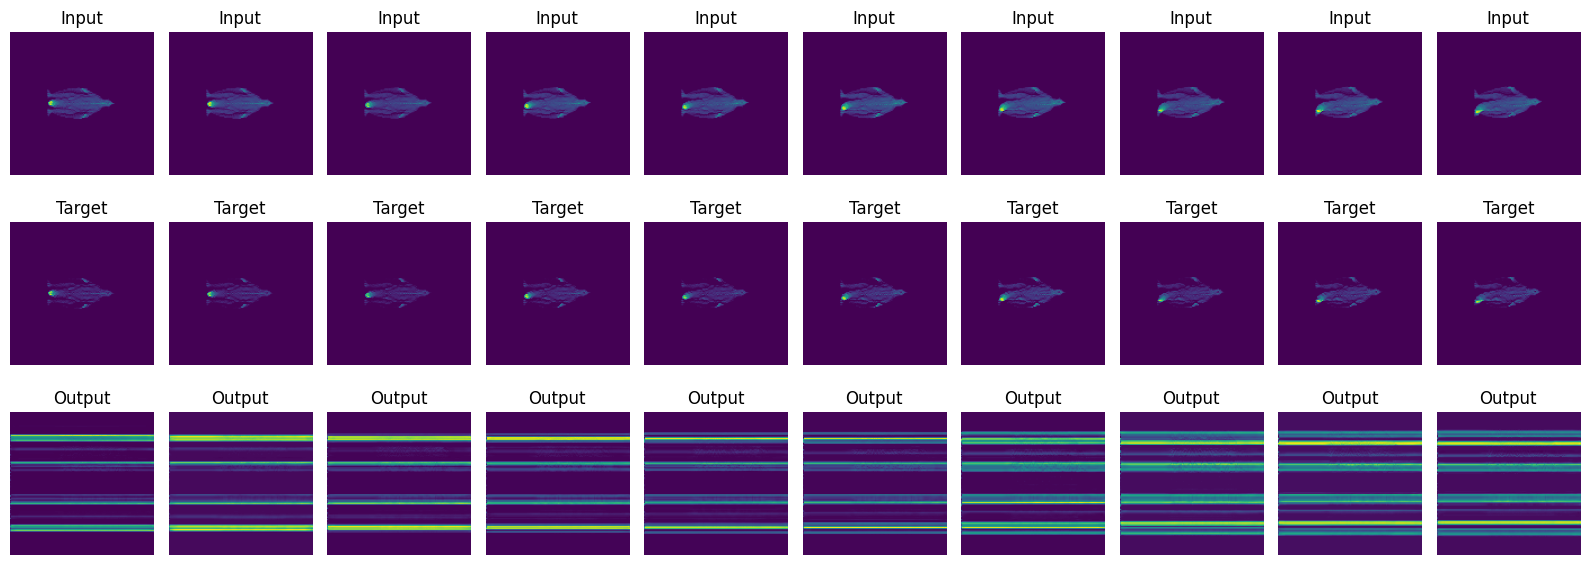

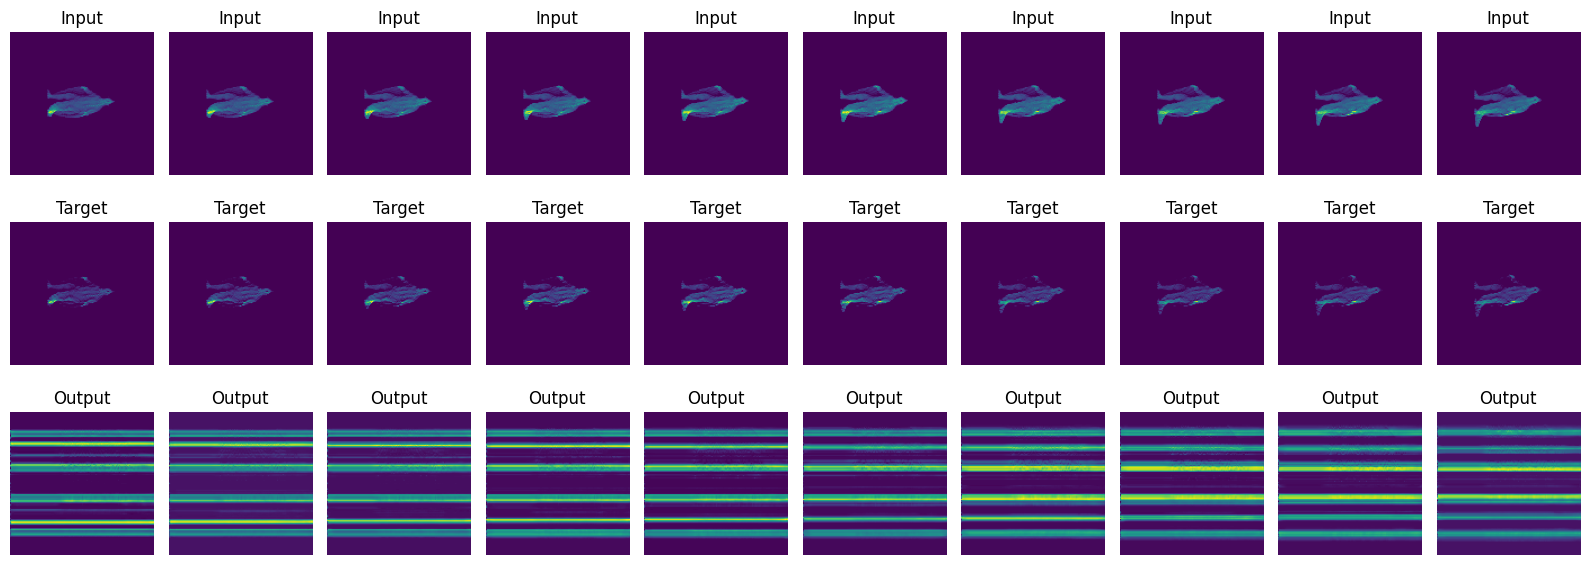

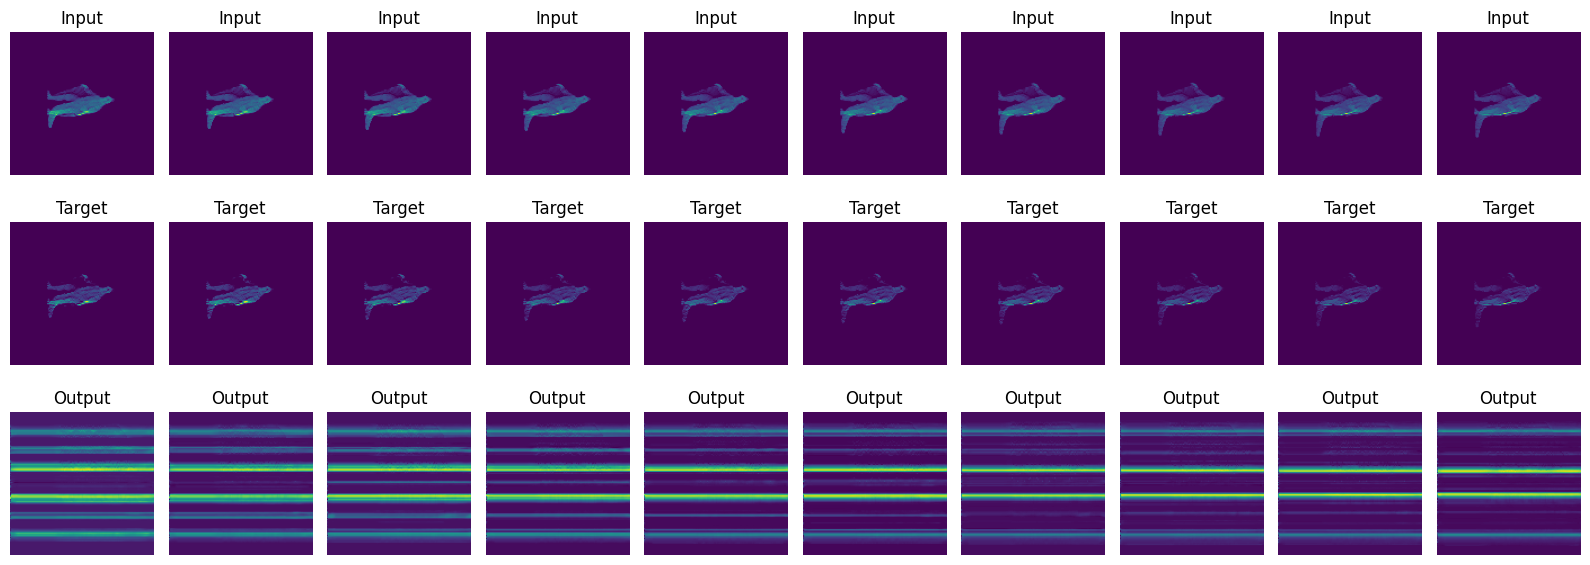

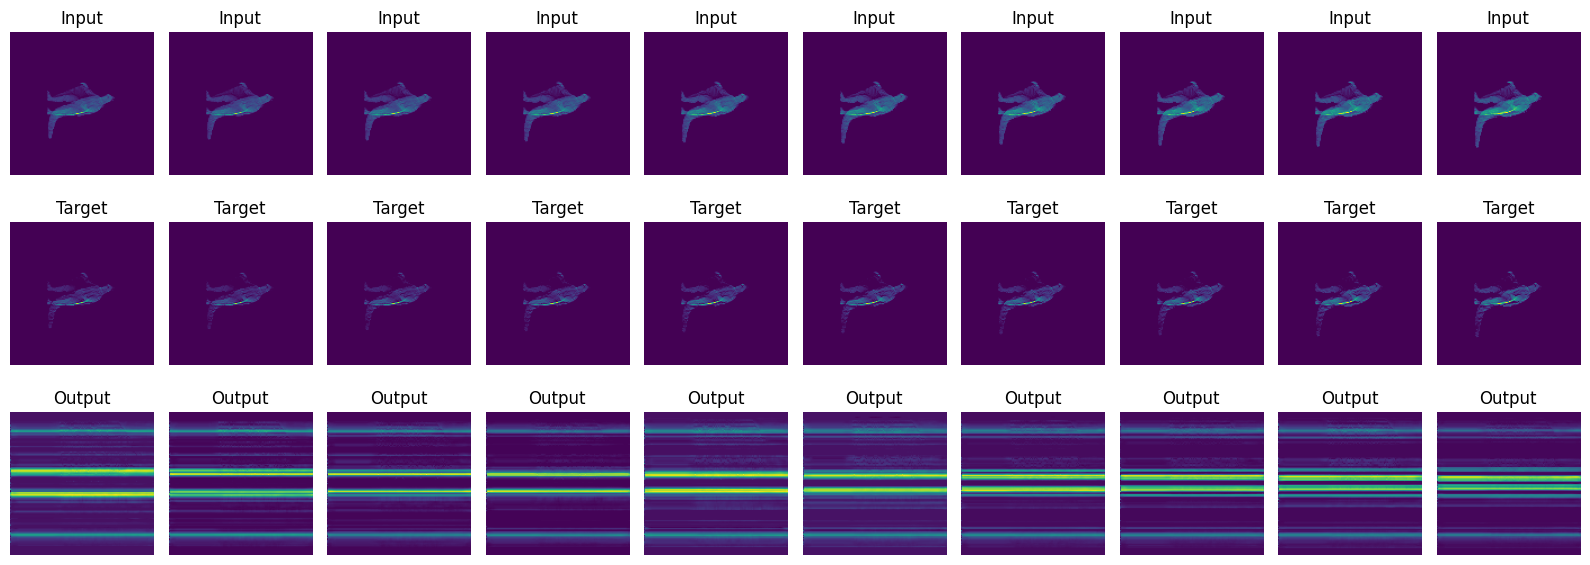

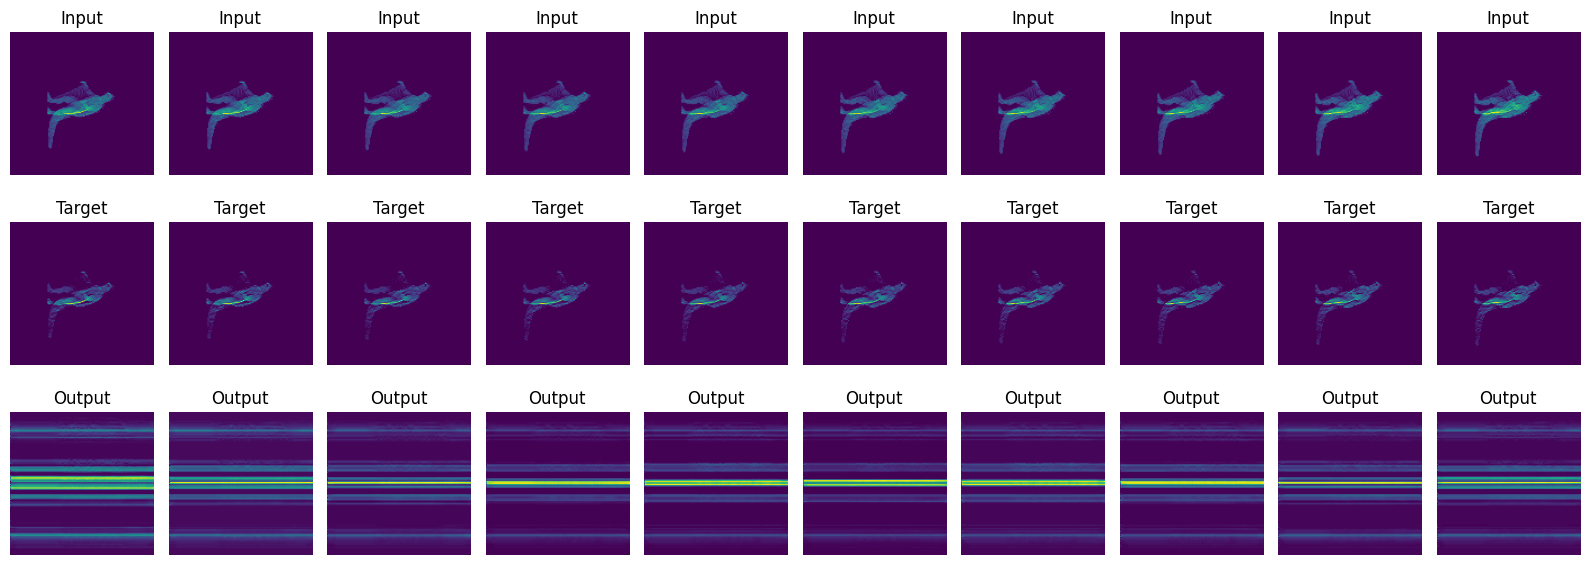

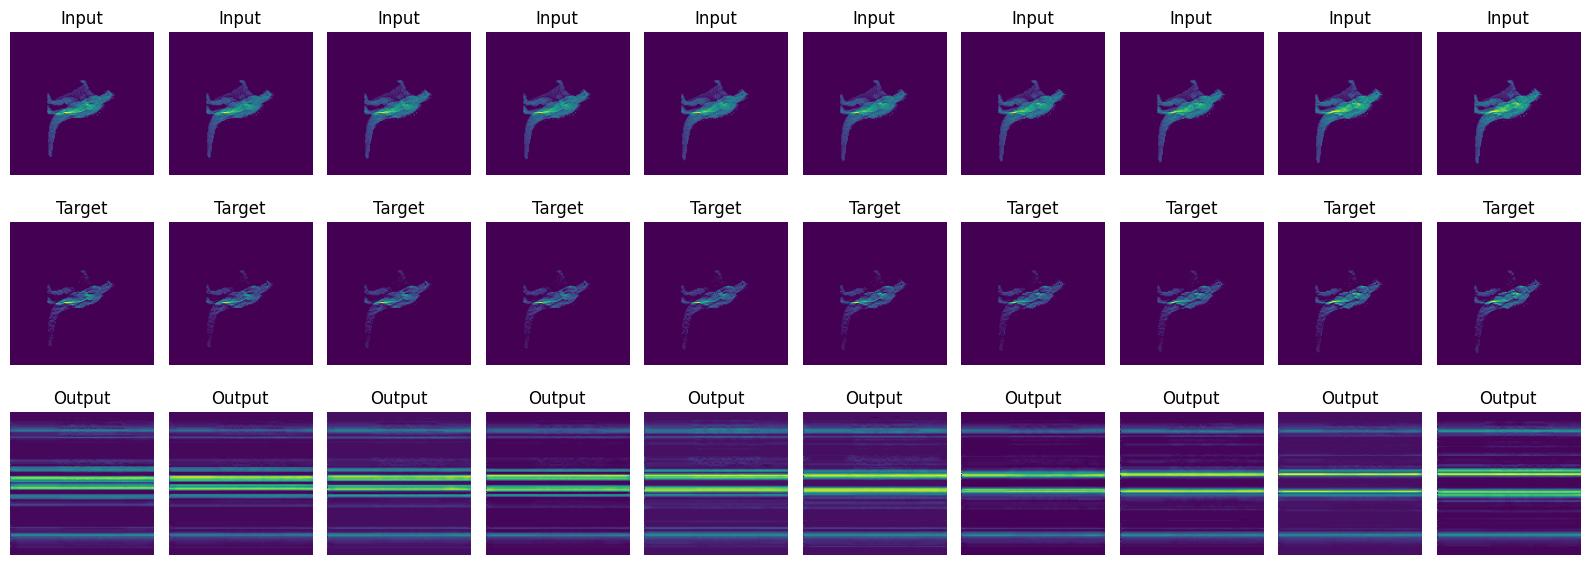

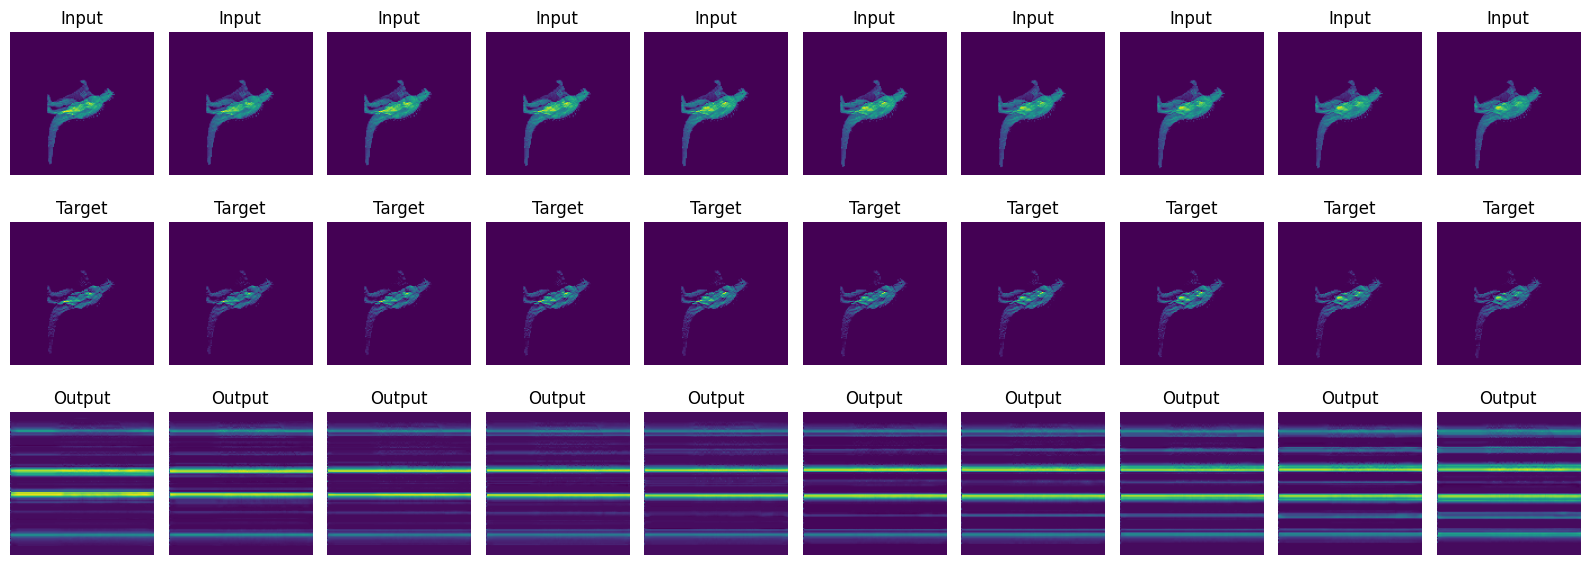

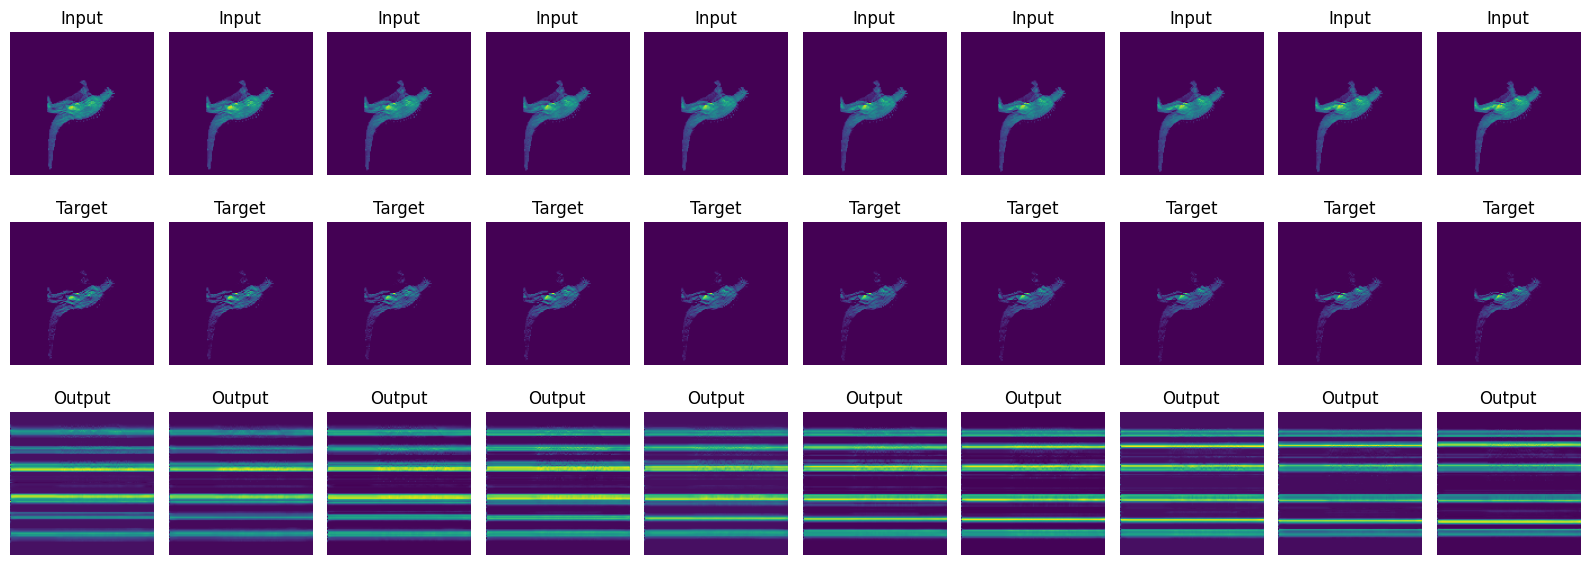

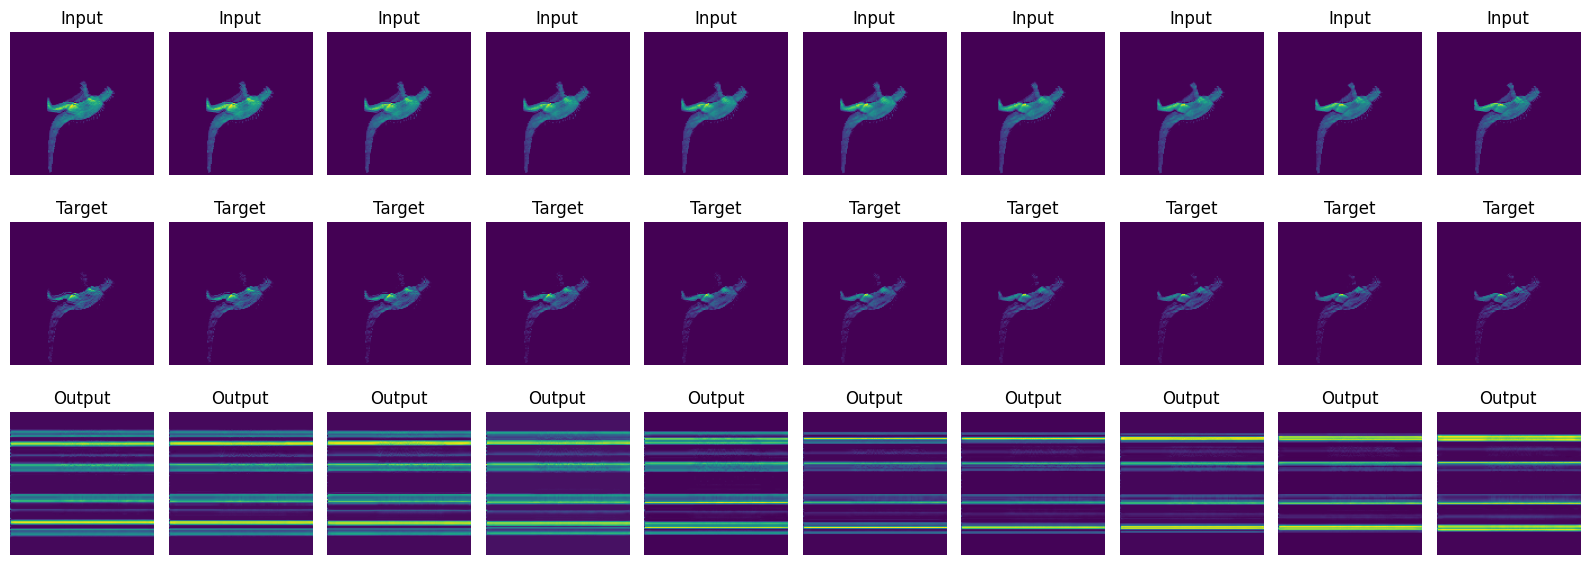

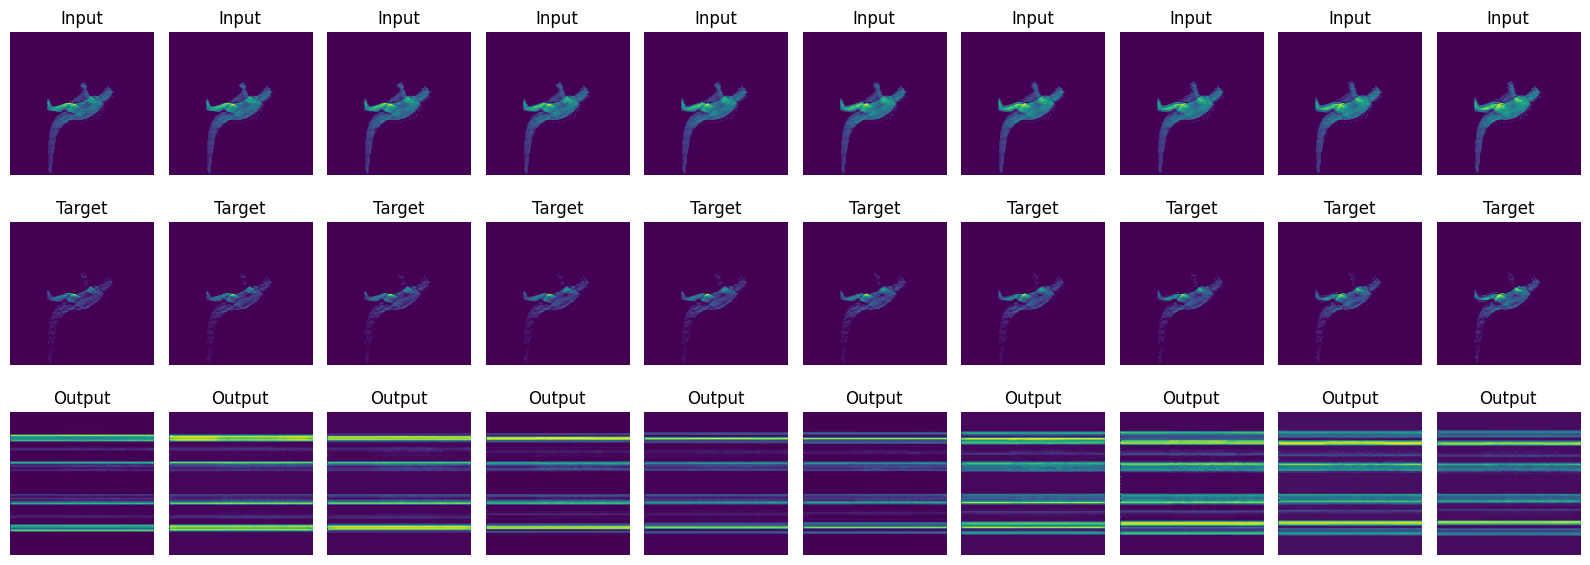

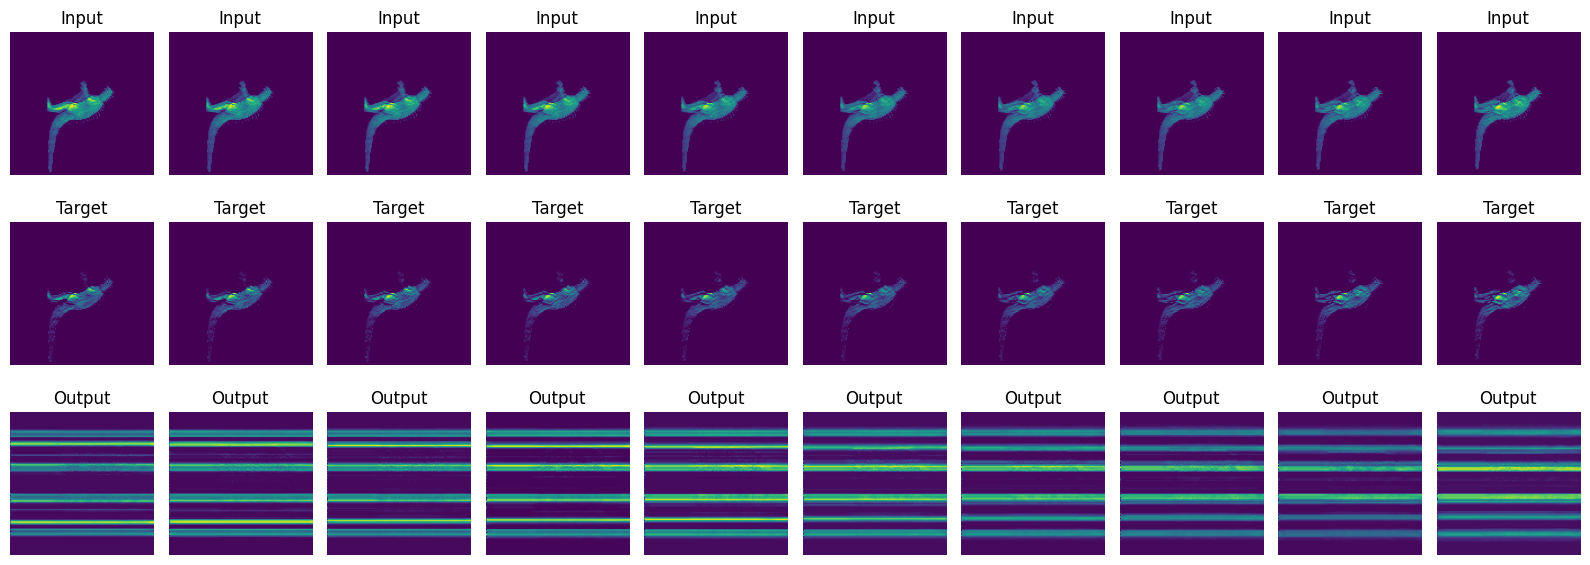

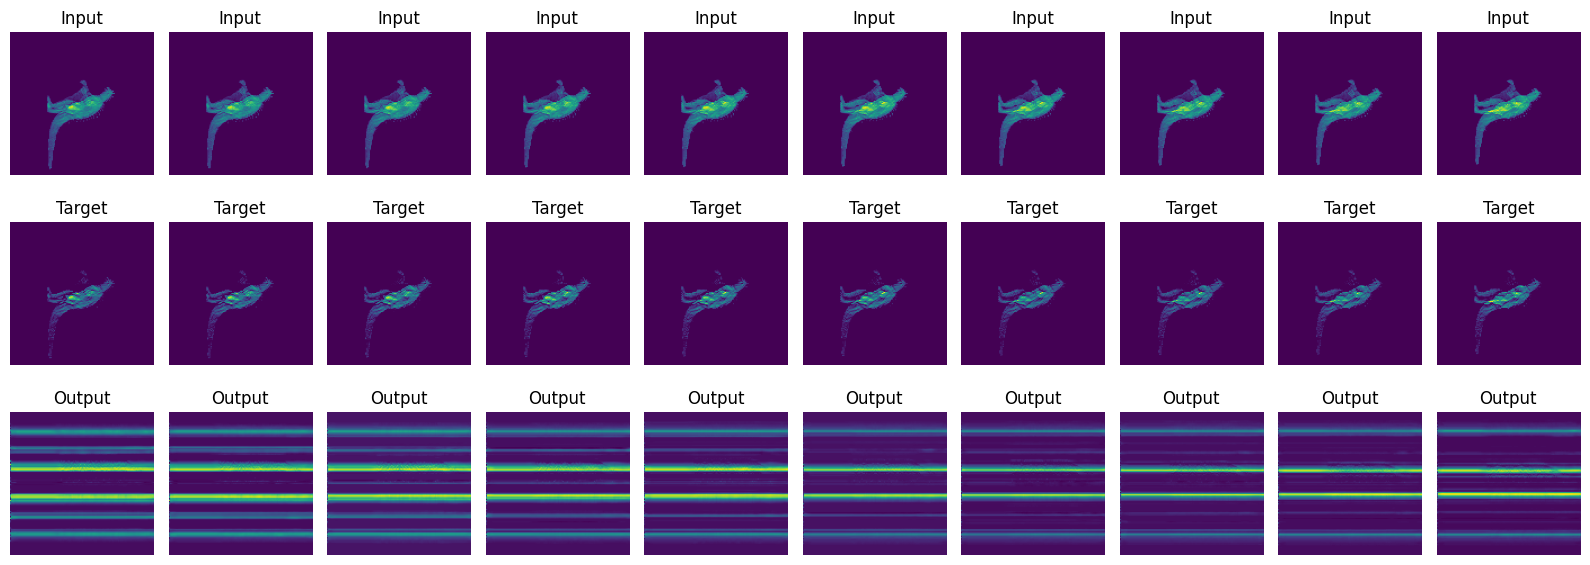

KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt


# List to store image outputs for all batches
example_outputs = []
count = 0
# Iterate through batches from the validation dataloader
for batch in dataloader:
    print(count)
    example_inputs, example_targets = batch
    example_inputs = example_inputs.to(device)
    example_targets = example_targets.to(device)
    count+=1

    # Forward pass through the model
    with torch.no_grad():
        image_output = model(example_inputs)
    
    # Append the output to the list
    example_outputs.append(image_output.cpu().numpy())

# Convert the list to a numpy array
example_outputs = np.concatenate(example_outputs)

# Convert the tensors to numpy arrays
example_inputs = example_inputs.cpu().numpy()
example_targets = example_targets.cpu().numpy()

# Reshape the example inputs, targets, and outputs if needed
# (Assuming the inputs and outputs have shape (batch_size, channels, height, width))
example_inputs = example_inputs.transpose(0, 2, 3, 1)
example_targets = example_targets.transpose(0, 2, 3, 1)
example_outputs = example_outputs.transpose(0, 2, 3, 1)

# Plot the example inputs, targets, and outputs
for i in range (36):
    plt.figure(figsize=(16, 6))
    for j in range(10):
        plt.subplot(3, 10, j+1)
        plt.imshow(example_inputs[i*10+j])
        plt.title('Input')
        plt.axis('off')

        plt.subplot(3, 10, 10 + j + 1)
        plt.imshow(example_targets[i*10+j])
        plt.title('Target')
        plt.axis('off')

        plt.subplot(3, 10, 20 + j + 1)
        plt.imshow(example_outputs[i*10+j])
        plt.title('Output')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

end_time = time.time()
print(end_time-start_time)